In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random
from collections import Counter
from math import log,sqrt
import numpy as np
from matplotlib import colors

In [2]:
data_path = '../../data/tfidf_tsne/'

In [3]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [4]:
fandom_list

['doctor_who_&_related_fandoms_tfidf_tsne.tsv',
 'shakespare_william_works_tfidf_tsne.tsv',
 'dragon_age_all_media_types_tfidf_tsne.tsv',
 'supernatural_tfidf_tsne.tsv',
 'buffy_the_vampire_slayer_tfidf_tsne.tsv',
 'homestuck_tfidf_tsne.tsv',
 'attack_on_titan_tfidf_tsne.tsv',
 'arthurian_mythology_&_related_fandoms_tfidf_tsne.tsv',
 'harry_potter_tfidf_tsne.tsv',
 'ms_paint_adventures_tfidf_tsne.tsv',
 'marvel_tfidf_tsne.tsv',
 'sherlock_holmes_&_related_fandoms_tfidf_tsne.tsv',
 'naruto_tfidf_tsne.tsv',
 'hamilton_miranda_tfidf_tsne.tsv',
 'haikyuu_tfidf_tsne.tsv',
 'hetalia_axis_powers_tfidf_tsne.tsv',
 'one_direction_tfidf_tsne.tsv',
 'bishoujo_senshi_sailor_moon_tfidf_tsne.tsv',
 'the_walking_dead_&_related_fandoms_tfidf_tsne.tsv',
 'les_miserables_all_media_types_tfidf_tsne.tsv',
 'dcu_tfidf_tsne.tsv',
 'kuroko_no_basuke_tfidf_tsne.tsv',
 'star_wars_all_media_types_tfidf_tsne.tsv',
 'tolkien_j_r_r_works_&_related_fandoms_tfidf_tsne.tsv']

### tsne clustering

In [5]:
df = pd.read_csv(os.path.join(data_path,'tolkien_j_r_r_works_&_related_fandoms_tfidf_tsne.tsv'), sep = '\t')
df = df[df['pc2'] > -40]
print(dict(df))

{'index': 0       3188
1      75548
2      87406
3        403
4       5135
5      66613
6      33415
7      71948
8      65086
9      62049
10     93649
11      9335
12     39006
13     53397
14     31377
15     70753
16     96543
17     25246
18      6367
19     22876
20      4323
21     60475
22     61157
23     60353
24     51022
25     13692
26     85458
27      6340
28     31013
29     42205
       ...  
970    72534
971    84403
972    21402
973    26967
974    36301
975    72750
976    21399
977     6506
978    40201
979    47426
980    92906
981    62508
982    50650
983    58088
984    12143
985     6087
986    73253
987    88982
988    23916
989     9819
990    95427
991    15725
992    33864
993    57563
994    88817
995    32396
996    59702
997    26886
998    78538
999    35209
Name: index, Length: 1000, dtype: int64, 'AdditionalTags': 0      Alternate Universe - Modern Setting, Alternate...
1                                                    NaN
2                       

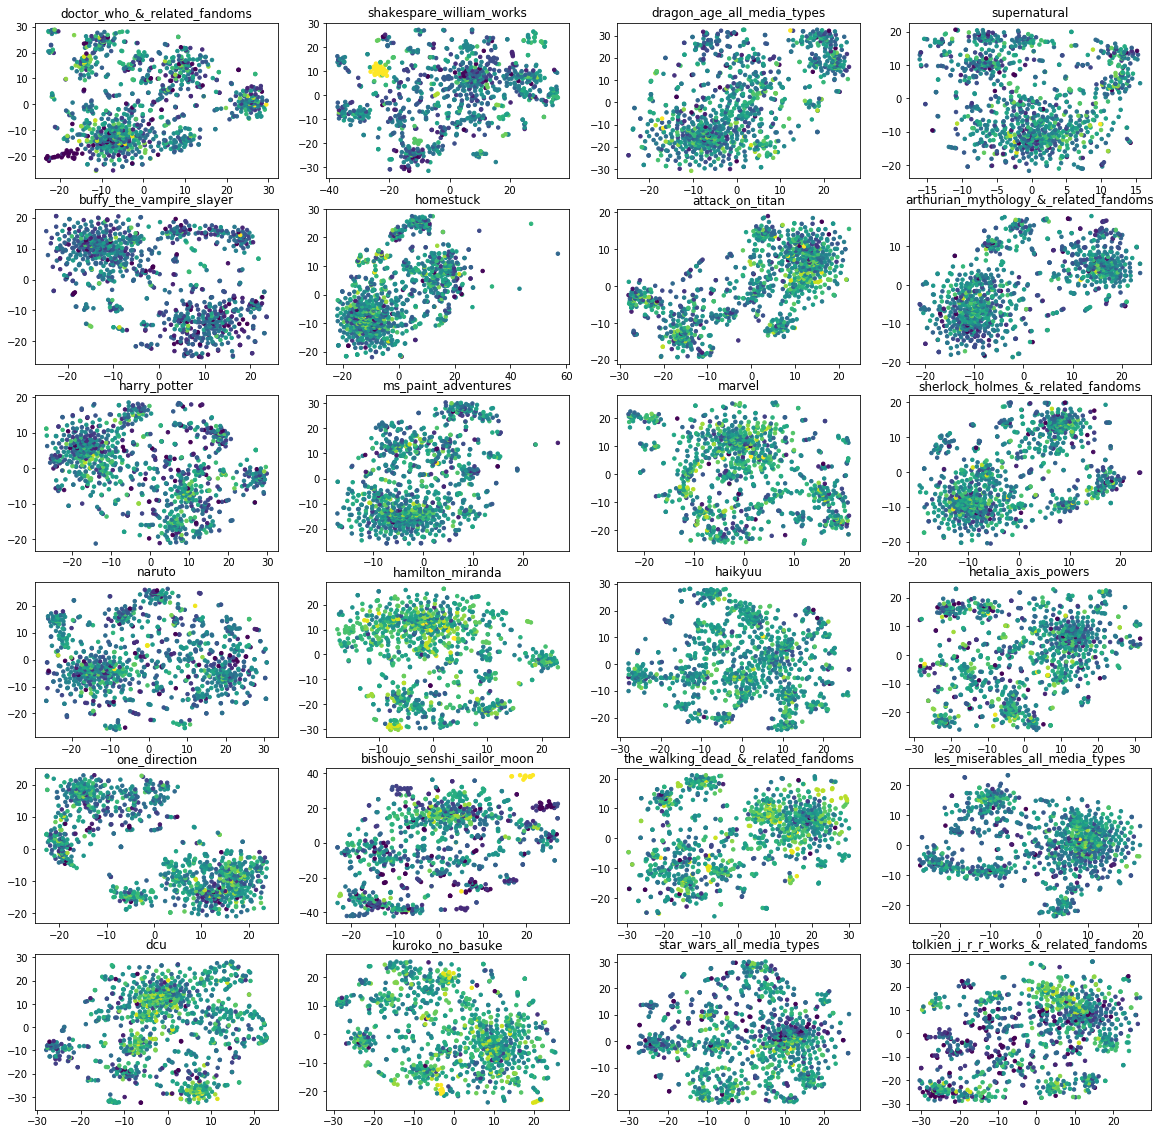

In [25]:
plt.figure(figsize = (20,20))
for i,fandom in enumerate(fandom_list):

    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    df = df.sort_values(by = "pc1")[10:-10]
    df = df.sort_values(by = "pc2")[10:-10]
    df['Kudos'] = np.log(df['Kudos']+1/df['Chapters'])
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    kmin = min(df['Kudos'])
    kmax = max(df['Kudos'])
    
    plt.subplot(6,4,i+1)
    norm = colors.Normalize(vmin = kmin, vmax = kmax)
    plt.scatter(df['pc1'], df['pc2'], c=df['Kudos'], norm = norm, cmap = 'viridis', s = 12)
    plt.title(fandom.replace('_tfidf_tsne.tsv', ''))
    plt.savefig('tsne_plot_rmoutliers.pdf', type='pdf')


### Look at the fics

In [ ]:
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    plt.figure()
    plt.scatter(df['pc1'], df['pc2'],alpha=0.7,c='blue')
    l = 0
    for label, x, y in zip(df['URL'], df['pc1'], df['pc2']):
        r = random.randint(0,100)
        if r % 50 == 0:
            plt.annotate(l, xy = (x,y),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
            print(l, ":", label)
            l += 1

    plt.title(fandom)
    break

In [ ]:
def find_close(vec, df):
    min_dist = (0,1)
    for row in df.iterrows():
        row_vec = [row[1]['pc1'], row[1]['pc2']]
        if vec != row_vec:
            if spatial.distance.cosine(vec,row_vec) < min_dist[1]:
                min_dist = (row[0], spatial.distance.cosine(vec,row_vec))
    return min_dist

In [ ]:
df.columns.values

In [ ]:
df['closest'] = df.apply(lambda row: find_close([row['pc1'], row['pc2']], df), axis=1 )

In [ ]:
df.head(2)

In [ ]:
df.iloc[2].URL

### Look at the overrepresented words

In [ ]:
def logodds(corpora_dic, bg_counter):
    """ It calculates the log odds ratio of term i's frequency between 
    a target corpus and another corpus, with the prior information from
    a background corpus. Inputs are:
    
    - a dictionary of Counter objects (corpora of our interest)
    - a Counter objects (background corpus)
    
    Output is a dictionary of dictionaries. Each dictionary contains the log 
    odds ratio of each word. 
    
    """
    corp_size = dict([(c, sum(corpora_dic[c].values())) for c in corpora_dic])
    bg_size = sum(bg_counter.values())
    result = dict([(c, {}) for c in corpora_dic])
    
    for name, c in corpora_dic.items():
        for word in c:
            #if 10 > sum(1 for corpus in corpora_dic.values() if corpus[word]):
            #    continue
            
            fi = c[word]
            fj = sum(co[word] for x, co in corpora_dic.items() if x != name)
            fbg = bg_counter[word]
            ni = corp_size[name]
            nj = sum(x for idx, x in corp_size.items() if idx != name)
            nbg = bg_size
            oddsratio = log(fi+fbg) - log(ni+nbg-(fi+fbg)) -\
                        log(fj+fbg) + log(nj+nbg-(fj+fbg))
            std = 1.0 / (fi+fbg) + 1.0 / (fj+fbg)
            z = oddsratio / sqrt(std)
            result[name][word] = z
            
    return result

In [ ]:
text = []
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    for line in df.Text.tolist():
        text.extend(word.lower() for word in line.split())
bg = Counter(text)

In [ ]:
def overrep_words(row, corp_b, bg):
    text = [word.lower() for word in row.split()]
    corp_a = Counter(text)
    result = logodds({'fic':corp_a, 'fandom':corp_b}, bg)
#     for k in sorted(result['fic'], key=result['fic'].get, reverse=True):
#         print(k,result['fic'][k])
    return sorted(result['fic'], key=result['fic'].get)[0:20]

In [ ]:
df.columns.values

In [ ]:
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    df = df.sample(100)
    text = []
    for line in df.Text.tolist():
        text.extend(word.lower() for word in line.split())
    corp_b = Counter(text)
    df['overrep_words'] = df['Text'].apply(lambda x: overrep_words(x, corp_b, bg))
    plt.figure(figsize = (12, 10))
    plt.scatter(df['pc1'], df['pc2'],alpha=0.7,c='blue')
    l = 0
    for label, x, y in zip(df['overrep_words'], df['pc1'], df['pc2']):
        r = random.randint(0,100)
        if r % 10 == 0:
            plt.annotate(l, xy = (x,y),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
            print(l, ":", label)
            l += 1
    plt.title(fandom)